# Render a Nerfie video!

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook renders a figure-8 orbit video using the test cameras generated in the capture processing notebook.

You can also load your own custom cameras by modifying the code slightly.

### Instructions

1. Convert a video into our dataset format using the [capture processing notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb).
2. Train a Nerfie model using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb)
3. Run this notebook!


### Notes
 * Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

In [1]:
# @title Define imports and utility functions.

import jax
from jax.config import config as jax_config
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import flax
import flax.linen as nn
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints
jax_config.enable_omnistaging() # Linen requires enabling omnistaging

from absl import logging
from io import BytesIO
import random as pyrandom
import numpy as np
import PIL
import IPython
import tempfile
import imageio
from IPython.display import display, HTML
from base64 import b64encode


# Monkey patch logging.
def myprint(msg, *args, **kwargs):
 print(msg % args)

logging.info = myprint 
logging.warn = myprint
logging.error = myprint


def show_image(image, fmt='png'):
    image = image_utils.image_to_uint8(image)
    f = BytesIO()
    PIL.Image.fromarray(image).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))


def show_video(frames, fps=30):
  with tempfile.NamedTemporaryFile(suffix='.mp4') as f:
    with imageio.get_writer(f.name, fps=fps) as writer:
      for frame in frames:
        writer.append_data(frame)

    with open(f.name,'rb') as f:
      data_url = "data:video/mp4;base64," + b64encode(f.read()).decode()
    display(HTML("""
    <video controls autoplay loop>
      <source src="%s" type="video/mp4">
    </video>
    """ % data_url))


/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/_src/config.py:163: UserWarning: enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;
see https://github.com/google/jax/blob/main/design_notes/omnistaging.md
  warnings.warn(


In [2]:
import os
os.chdir('/private/home/gengshany/code/vid2shape/third_party/nerfies-0.1/')

In [3]:
# @title Model and dataset configuration
# @markdown Change the directories to where you saved your capture and experiment.

import sys
sys.path.insert(0,'/private/home/gengshany/code/vid2shape/third_party/nerfies-0.1/')
from pathlib import Path
from pprint import pprint
import gin
from IPython.display import display, Markdown

from nerfies import configs

#seqname='cat_905'
#seqname='T_swing1'
seqname='T_samba1'
#seqname='a-eagle-1'
# @markdown The working directory where the trained model is.
train_dir = './logs/%s/'%(seqname)  # @param {type: "string"}
# @markdown The directory to the dataset capture.
data_dir = 'dataset/%s/'%(seqname)  # @param {type: "string"}

checkpoint_dir = Path(train_dir, 'checkpoints')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

config_path = '%s/config.gin'%(train_dir)
with open(config_path, 'r') as f:
  logging.info('Loading config from %s', config_path)
  config_str = f.read()
gin.parse_config(config_str)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'w') as f:
  logging.info('Saving config to %s', config_path)
  f.write(config_str)

exp_config = configs.ExperimentConfig()
model_config = configs.ModelConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()

display(Markdown(
    gin.config.markdownify_operative_config_str(gin.operative_config_str())))

Loading config from ./logs/T_samba1//config.gin
Saving config to logs/T_samba1/config.gin


#### Macros:

    ANNEALED_WARP_ALPHA_SCHED = \
        {'final_value': %num_warp_freqs,
         'initial_value': 0.0,
         'num_steps': 80000,
         'type': 'linear'}
    batch_size = 4096
    DECAYING_ELASTIC_LOSS_SCHED = \
        {'schedules': [(50000, ('constant', %elastic_init_weight)),
                       (100000,
                        ('cosine_easing', %elastic_init_weight, 1e-08, 100000))],
         'type': 'piecewise'}
    elastic_init_weight = 0.01
    final_lr = 0.0001
    image_scale = 4
    init_lr = 0.001
    lr_decay_steps = 500000
    max_steps = 250000
    num_warp_freqs = 8
    
#### Parameters for EvalConfig:

    EvalConfig.chunk = 8192
    EvalConfig.eval_once = False
    EvalConfig.num_test_eval = 10
    EvalConfig.num_train_eval = 10
    EvalConfig.num_val_eval = None
    EvalConfig.save_output = True
    
#### Parameters for ExperimentConfig:

    ExperimentConfig.datasource_spec = None
    ExperimentConfig.datasource_type = 'nerfies'
    ExperimentConfig.image_scale = %image_scale
    ExperimentConfig.random_seed = 12345
    ExperimentConfig.subname = None
    
#### Parameters for ModelConfig:

    ModelConfig.alpha_channels = 1
    ModelConfig.appearance_metadata_dims = 8
    ModelConfig.camera_metadata_dims = 2
    ModelConfig.nerf_condition_depth = 1
    ModelConfig.nerf_condition_width = 128
    ModelConfig.nerf_skips = (4,)
    ModelConfig.nerf_trunk_depth = 8
    ModelConfig.nerf_trunk_width = 256
    ModelConfig.noise_std = None
    ModelConfig.num_coarse_samples = 128
    ModelConfig.num_fine_samples = 128
    ModelConfig.num_nerf_point_freqs = 8
    ModelConfig.num_nerf_viewdir_freqs = 4
    ModelConfig.num_warp_features = 8
    ModelConfig.num_warp_freqs = %num_warp_freqs
    ModelConfig.rgb_channels = 3
    ModelConfig.sigma_activation = @nn.softplus
    ModelConfig.use_appearance_metadata = True
    ModelConfig.use_camera_metadata = False
    ModelConfig.use_linear_disparity = False
    ModelConfig.use_sample_at_infinity = True
    ModelConfig.use_stratified_sampling = True
    ModelConfig.use_viewdirs = True
    ModelConfig.use_warp = True
    ModelConfig.use_white_background = False
    ModelConfig.warp_field_type = 'se3'
    
#### Parameters for TrainConfig:

    TrainConfig.background_loss_weight = 1.0
    TrainConfig.background_points_batch_size = 16384
    TrainConfig.batch_size = %batch_size
    TrainConfig.elastic_loss_weight_schedule = %DECAYING_ELASTIC_LOSS_SCHED
    TrainConfig.elastic_reduce_method = 'weight'
    TrainConfig.log_every = 500
    TrainConfig.lr_schedule = \
        {'final_value': %final_lr,
         'initial_value': %init_lr,
         'num_steps': %lr_decay_steps,
         'type': 'exponential'}
    TrainConfig.max_steps = %max_steps
    TrainConfig.print_every = 200
    TrainConfig.save_every = 5000
    TrainConfig.use_background_loss = False
    TrainConfig.use_elastic_loss = True
    TrainConfig.warp_alpha_schedule = %ANNEALED_WARP_ALPHA_SCHED

*** Loading dataset IDs from dataset/T_samba1/dataset.json


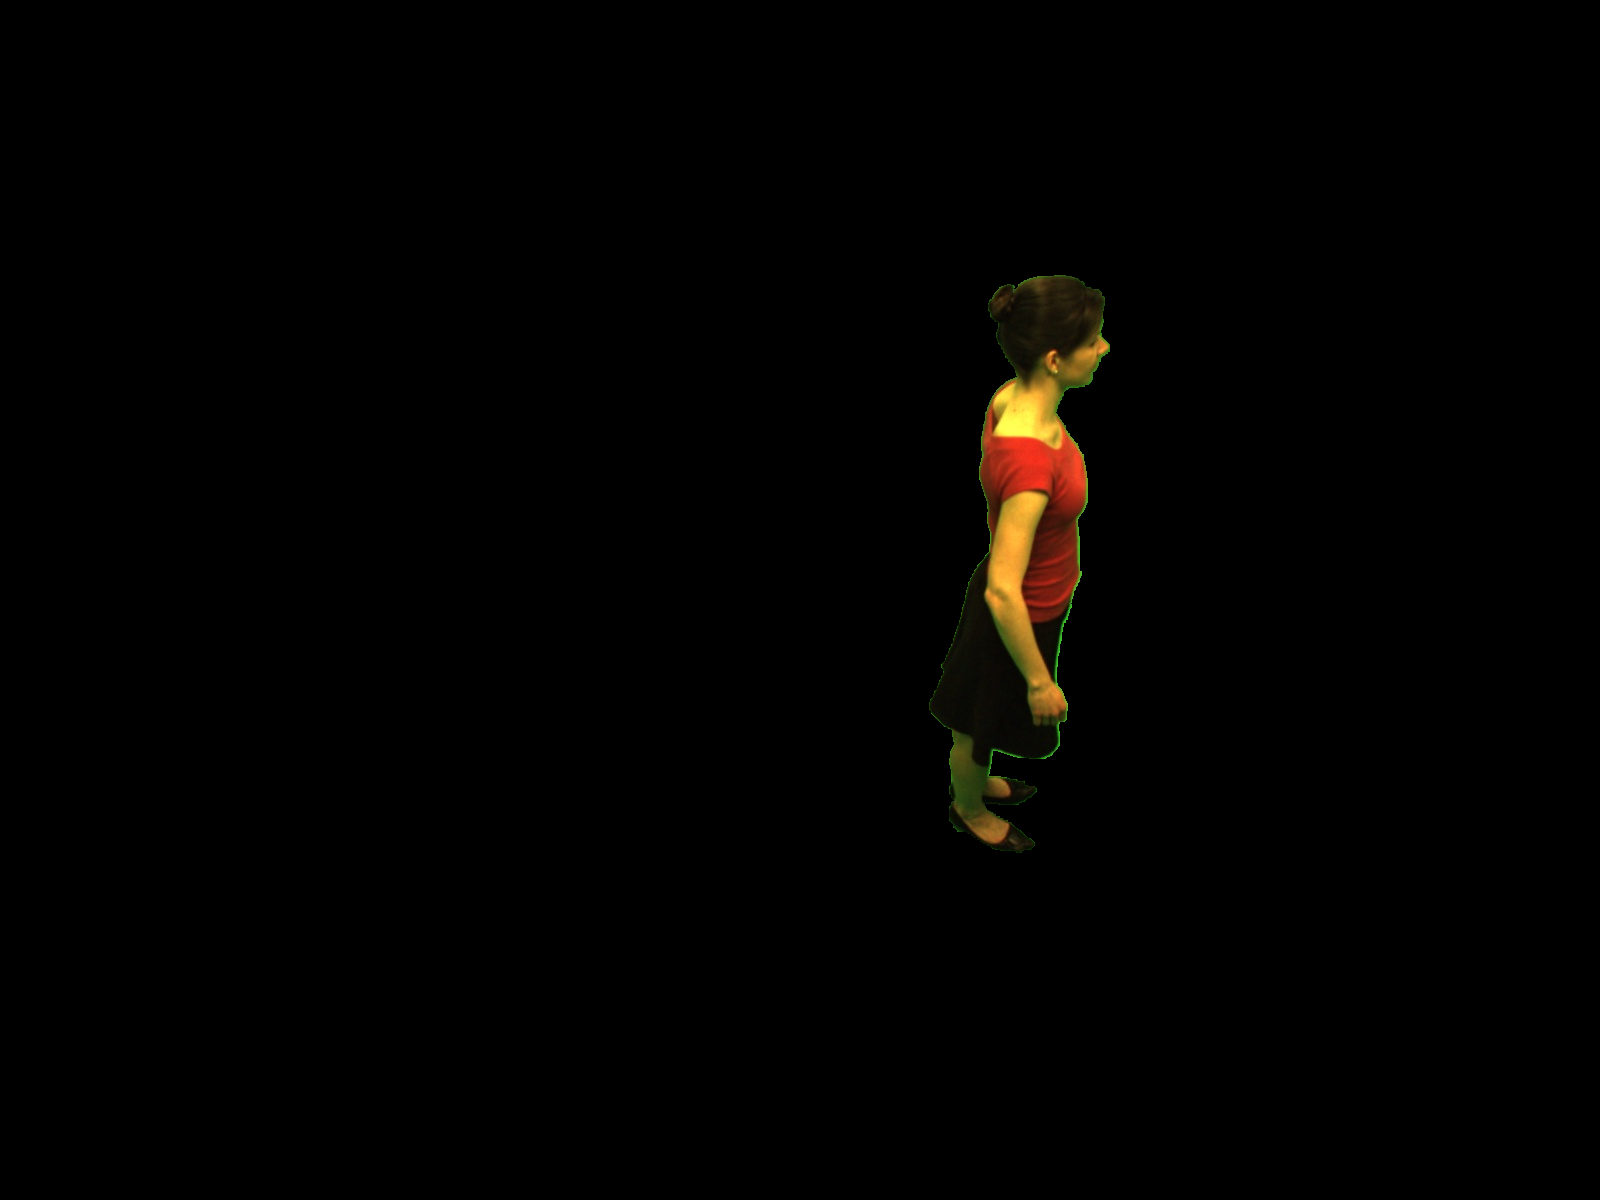

In [4]:
# @title Create datasource and show an example.

from nerfies import datasets
from nerfies import image_utils

datasource_spec = exp_config.datasource_spec
if datasource_spec is None:
    datasource_spec = {
        'type': exp_config.datasource_type,
        'data_dir': data_dir,
    }
datasource = datasets.from_config(
  datasource_spec,
  #image_scale=exp_config.image_scale,
  image_scale=1,
  use_appearance_id=model_config.use_appearance_metadata,
  use_camera_id=model_config.use_camera_metadata,
  use_warp_id=model_config.use_warp,
  random_seed=exp_config.random_seed)

show_image(datasource.load_rgb(datasource.train_ids[0]))

In [5]:
# @title Initialize model
# @markdown Defines the model and initializes its parameters.

from flax.training import checkpoints
from nerfies import models
from nerfies import model_utils
from nerfies import schedules
from nerfies import training


rng = random.PRNGKey(exp_config.random_seed)
np.random.seed(exp_config.random_seed + jax.host_id())
devices = jax.devices()

learning_rate_sched = schedules.from_config(train_config.lr_schedule)
warp_alpha_sched = schedules.from_config(train_config.warp_alpha_schedule)
elastic_loss_weight_sched = schedules.from_config(
    train_config.elastic_loss_weight_schedule)

rng, key = random.split(rng)
params = {}
model, params['model'] = models.nerf(
    key,
    model_config,
    batch_size=train_config.batch_size,
    num_appearance_embeddings=len(datasource.appearance_ids),
    num_camera_embeddings=len(datasource.camera_ids),
    num_warp_embeddings=len(datasource.warp_ids),
    near=datasource.near,
    far=datasource.far,
    use_warp_jacobian=train_config.use_elastic_loss,
    use_weights=train_config.use_elastic_loss)

optimizer_def = optim.Adam(learning_rate_sched(0))
optimizer = optimizer_def.create(params)
state = model_utils.TrainState(
    optimizer=optimizer,
    warp_alpha=warp_alpha_sched(0))
scalar_params = training.ScalarParams(
    learning_rate=learning_rate_sched(0),
    elastic_loss_weight=elastic_loss_weight_sched(0),
    background_loss_weight=train_config.background_loss_weight)
logging.info('Restoring checkpoint from %s', checkpoint_dir)
#state = checkpoints.restore_checkpoint(checkpoint_dir, state,step=1000)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)
step = state.optimizer.state.step + 1
state = jax_utils.replicate(state, devices=devices)
del params

Starting the local TPU driver.
Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/lib/xla_bridge.py:369: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


Restoring checkpoint from logs/T_samba1/checkpoints
Restoring checkpoint from logs/T_samba1/checkpoints/checkpoint_15000


In [6]:
# @title Define pmapped render function.

import functools
from nerfies import evaluation
from importlib import reload  

devices = jax.devices()


def _model_fn(key_0, key_1, params, rays_dict, alpha):
  out = model.apply({'params': params},
                    rays_dict,
                    warp_alpha=alpha,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1
                    },
                    mutable=False)
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    # key0, key1, params, rays_dict, alpha
    in_axes=(0, 0, 0, 0, 0),
    devices=devices,
    donate_argnums=(3,),  # Donate the 'rays' argument.
    axis_name='batch',
)

render_fn = functools.partial(evaluation.render_image,
                              model_fn=pmodel_fn,
                              device_count=len(devices),
                              chunk=eval_config.chunk)

In [7]:
# @title Load cameras.

from nerfies import utils


test_camera_paths = datasource.glob_cameras(Path(data_dir, 'camera'))
#test_camera_paths = datasource.glob_cameras('dataset/syn-eagled-/camera/')
test_cameras = utils.parallel_map(datasource.load_camera, test_camera_paths, show_pbar=True)

100%|████████████████████████████████████████████████████| 175/175 [00:00<00:00, 381.90it/s]


In [8]:
# @title Render video frames.
import ipyplot
from nerfies import visualization as viz

rng = rng + jax.host_id()  # Make random seed separate across hosts.
keys = random.split(rng, len(devices))

results = []
for i in range(len(test_cameras)):
 # if i%10!=0 or i>100:continue
  print(f'Rendering frame {i+1}/{len(test_cameras)}')
  camera = test_cameras[i]
  batch = datasets.camera_to_rays(camera)
  batch['metadata'] = {
      'appearance': i*jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32),
      'warp': i*jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32),
  }

  pred_color, pred_depth, pred_depth_med, pred_acc = render_fn(state, batch, rng=rng)
  results.append((pred_color, pred_depth, pred_acc))
  pred_depth_viz = viz.colorize(pred_depth.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  ##break

Rendering frame 1/175
	Rendering ray batch: 0/1920000


/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/lib/xla_bridge.py:382: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


	Rendering ray batch: 8192/1920000
	Rendering ray batch: 16384/1920000
	Rendering ray batch: 24576/1920000
	Rendering ray batch: 32768/1920000
	Rendering ray batch: 40960/1920000
	Rendering ray batch: 49152/1920000
	Rendering ray batch: 57344/1920000
	Rendering ray batch: 65536/1920000
	Rendering ray batch: 73728/1920000
	Rendering ray batch: 81920/1920000
	Rendering ray batch: 90112/1920000
	Rendering ray batch: 98304/1920000
	Rendering ray batch: 106496/1920000
	Rendering ray batch: 114688/1920000
	Rendering ray batch: 122880/1920000
	Rendering ray batch: 131072/1920000
	Rendering ray batch: 139264/1920000
	Rendering ray batch: 147456/1920000
	Rendering ray batch: 155648/1920000
	Rendering ray batch: 163840/1920000
	Rendering ray batch: 172032/1920000
	Rendering ray batch: 180224/1920000
	Rendering ray batch: 188416/1920000
	Rendering ray batch: 196608/1920000
	Rendering ray batch: 204800/1920000
	Rendering ray batch: 212992/1920000
	Rendering ray batch: 221184/1920000
	Rendering ray

	Rendering ray batch: 1810432/1920000
	Rendering ray batch: 1818624/1920000
	Rendering ray batch: 1826816/1920000
	Rendering ray batch: 1835008/1920000
	Rendering ray batch: 1843200/1920000
	Rendering ray batch: 1851392/1920000
	Rendering ray batch: 1859584/1920000
	Rendering ray batch: 1867776/1920000
	Rendering ray batch: 1875968/1920000
	Rendering ray batch: 1884160/1920000
	Rendering ray batch: 1892352/1920000
	Rendering ray batch: 1900544/1920000
	Rendering ray batch: 1908736/1920000
	Rendering ray batch: 1916928/1920000
Rendering took 372.
Rendering frame 2/175
	Rendering ray batch: 0/1920000
	Rendering ray batch: 8192/1920000
	Rendering ray batch: 16384/1920000
	Rendering ray batch: 24576/1920000
	Rendering ray batch: 32768/1920000
	Rendering ray batch: 40960/1920000
	Rendering ray batch: 49152/1920000
	Rendering ray batch: 57344/1920000
	Rendering ray batch: 65536/1920000
	Rendering ray batch: 73728/1920000
	Rendering ray batch: 81920/1920000
	Rendering ray batch: 90112/1920000

	Rendering ray batch: 1679360/1920000
	Rendering ray batch: 1687552/1920000
	Rendering ray batch: 1695744/1920000
	Rendering ray batch: 1703936/1920000
	Rendering ray batch: 1712128/1920000
	Rendering ray batch: 1720320/1920000
	Rendering ray batch: 1728512/1920000
	Rendering ray batch: 1736704/1920000
	Rendering ray batch: 1744896/1920000
	Rendering ray batch: 1753088/1920000
	Rendering ray batch: 1761280/1920000
	Rendering ray batch: 1769472/1920000
	Rendering ray batch: 1777664/1920000
	Rendering ray batch: 1785856/1920000
	Rendering ray batch: 1794048/1920000
	Rendering ray batch: 1802240/1920000
	Rendering ray batch: 1810432/1920000
	Rendering ray batch: 1818624/1920000
	Rendering ray batch: 1826816/1920000
	Rendering ray batch: 1835008/1920000
	Rendering ray batch: 1843200/1920000
	Rendering ray batch: 1851392/1920000
	Rendering ray batch: 1859584/1920000
	Rendering ray batch: 1867776/1920000
	Rendering ray batch: 1875968/1920000
	Rendering ray batch: 1884160/1920000
	Rendering r

	Rendering ray batch: 1548288/1920000
	Rendering ray batch: 1556480/1920000
	Rendering ray batch: 1564672/1920000
	Rendering ray batch: 1572864/1920000
	Rendering ray batch: 1581056/1920000
	Rendering ray batch: 1589248/1920000
	Rendering ray batch: 1597440/1920000
	Rendering ray batch: 1605632/1920000
	Rendering ray batch: 1613824/1920000
	Rendering ray batch: 1622016/1920000
	Rendering ray batch: 1630208/1920000
	Rendering ray batch: 1638400/1920000
	Rendering ray batch: 1646592/1920000
	Rendering ray batch: 1654784/1920000
	Rendering ray batch: 1662976/1920000
	Rendering ray batch: 1671168/1920000
	Rendering ray batch: 1679360/1920000
	Rendering ray batch: 1687552/1920000
	Rendering ray batch: 1695744/1920000
	Rendering ray batch: 1703936/1920000
	Rendering ray batch: 1712128/1920000
	Rendering ray batch: 1720320/1920000
	Rendering ray batch: 1728512/1920000
	Rendering ray batch: 1736704/1920000
	Rendering ray batch: 1744896/1920000
	Rendering ray batch: 1753088/1920000
	Rendering r

	Rendering ray batch: 1417216/1920000
	Rendering ray batch: 1425408/1920000
	Rendering ray batch: 1433600/1920000
	Rendering ray batch: 1441792/1920000
	Rendering ray batch: 1449984/1920000
	Rendering ray batch: 1458176/1920000
	Rendering ray batch: 1466368/1920000
	Rendering ray batch: 1474560/1920000
	Rendering ray batch: 1482752/1920000
	Rendering ray batch: 1490944/1920000
	Rendering ray batch: 1499136/1920000
	Rendering ray batch: 1507328/1920000
	Rendering ray batch: 1515520/1920000
	Rendering ray batch: 1523712/1920000
	Rendering ray batch: 1531904/1920000
	Rendering ray batch: 1540096/1920000
	Rendering ray batch: 1548288/1920000
	Rendering ray batch: 1556480/1920000
	Rendering ray batch: 1564672/1920000
	Rendering ray batch: 1572864/1920000
	Rendering ray batch: 1581056/1920000
	Rendering ray batch: 1589248/1920000
	Rendering ray batch: 1597440/1920000
	Rendering ray batch: 1605632/1920000
	Rendering ray batch: 1613824/1920000
	Rendering ray batch: 1622016/1920000
	Rendering r

	Rendering ray batch: 1286144/1920000
	Rendering ray batch: 1294336/1920000
	Rendering ray batch: 1302528/1920000
	Rendering ray batch: 1310720/1920000
	Rendering ray batch: 1318912/1920000
	Rendering ray batch: 1327104/1920000
	Rendering ray batch: 1335296/1920000
	Rendering ray batch: 1343488/1920000
	Rendering ray batch: 1351680/1920000
	Rendering ray batch: 1359872/1920000
	Rendering ray batch: 1368064/1920000
	Rendering ray batch: 1376256/1920000
	Rendering ray batch: 1384448/1920000
	Rendering ray batch: 1392640/1920000
	Rendering ray batch: 1400832/1920000
	Rendering ray batch: 1409024/1920000
	Rendering ray batch: 1417216/1920000
	Rendering ray batch: 1425408/1920000
	Rendering ray batch: 1433600/1920000
	Rendering ray batch: 1441792/1920000
	Rendering ray batch: 1449984/1920000
	Rendering ray batch: 1458176/1920000
	Rendering ray batch: 1466368/1920000
	Rendering ray batch: 1474560/1920000
	Rendering ray batch: 1482752/1920000
	Rendering ray batch: 1490944/1920000
	Rendering r

	Rendering ray batch: 1155072/1920000
	Rendering ray batch: 1163264/1920000
	Rendering ray batch: 1171456/1920000
	Rendering ray batch: 1179648/1920000
	Rendering ray batch: 1187840/1920000
	Rendering ray batch: 1196032/1920000
	Rendering ray batch: 1204224/1920000
	Rendering ray batch: 1212416/1920000
	Rendering ray batch: 1220608/1920000
	Rendering ray batch: 1228800/1920000
	Rendering ray batch: 1236992/1920000
	Rendering ray batch: 1245184/1920000
	Rendering ray batch: 1253376/1920000
	Rendering ray batch: 1261568/1920000
	Rendering ray batch: 1269760/1920000
	Rendering ray batch: 1277952/1920000
	Rendering ray batch: 1286144/1920000
	Rendering ray batch: 1294336/1920000
	Rendering ray batch: 1302528/1920000
	Rendering ray batch: 1310720/1920000
	Rendering ray batch: 1318912/1920000
	Rendering ray batch: 1327104/1920000
	Rendering ray batch: 1335296/1920000
	Rendering ray batch: 1343488/1920000
	Rendering ray batch: 1351680/1920000
	Rendering ray batch: 1359872/1920000
	Rendering r

KeyboardInterrupt: 

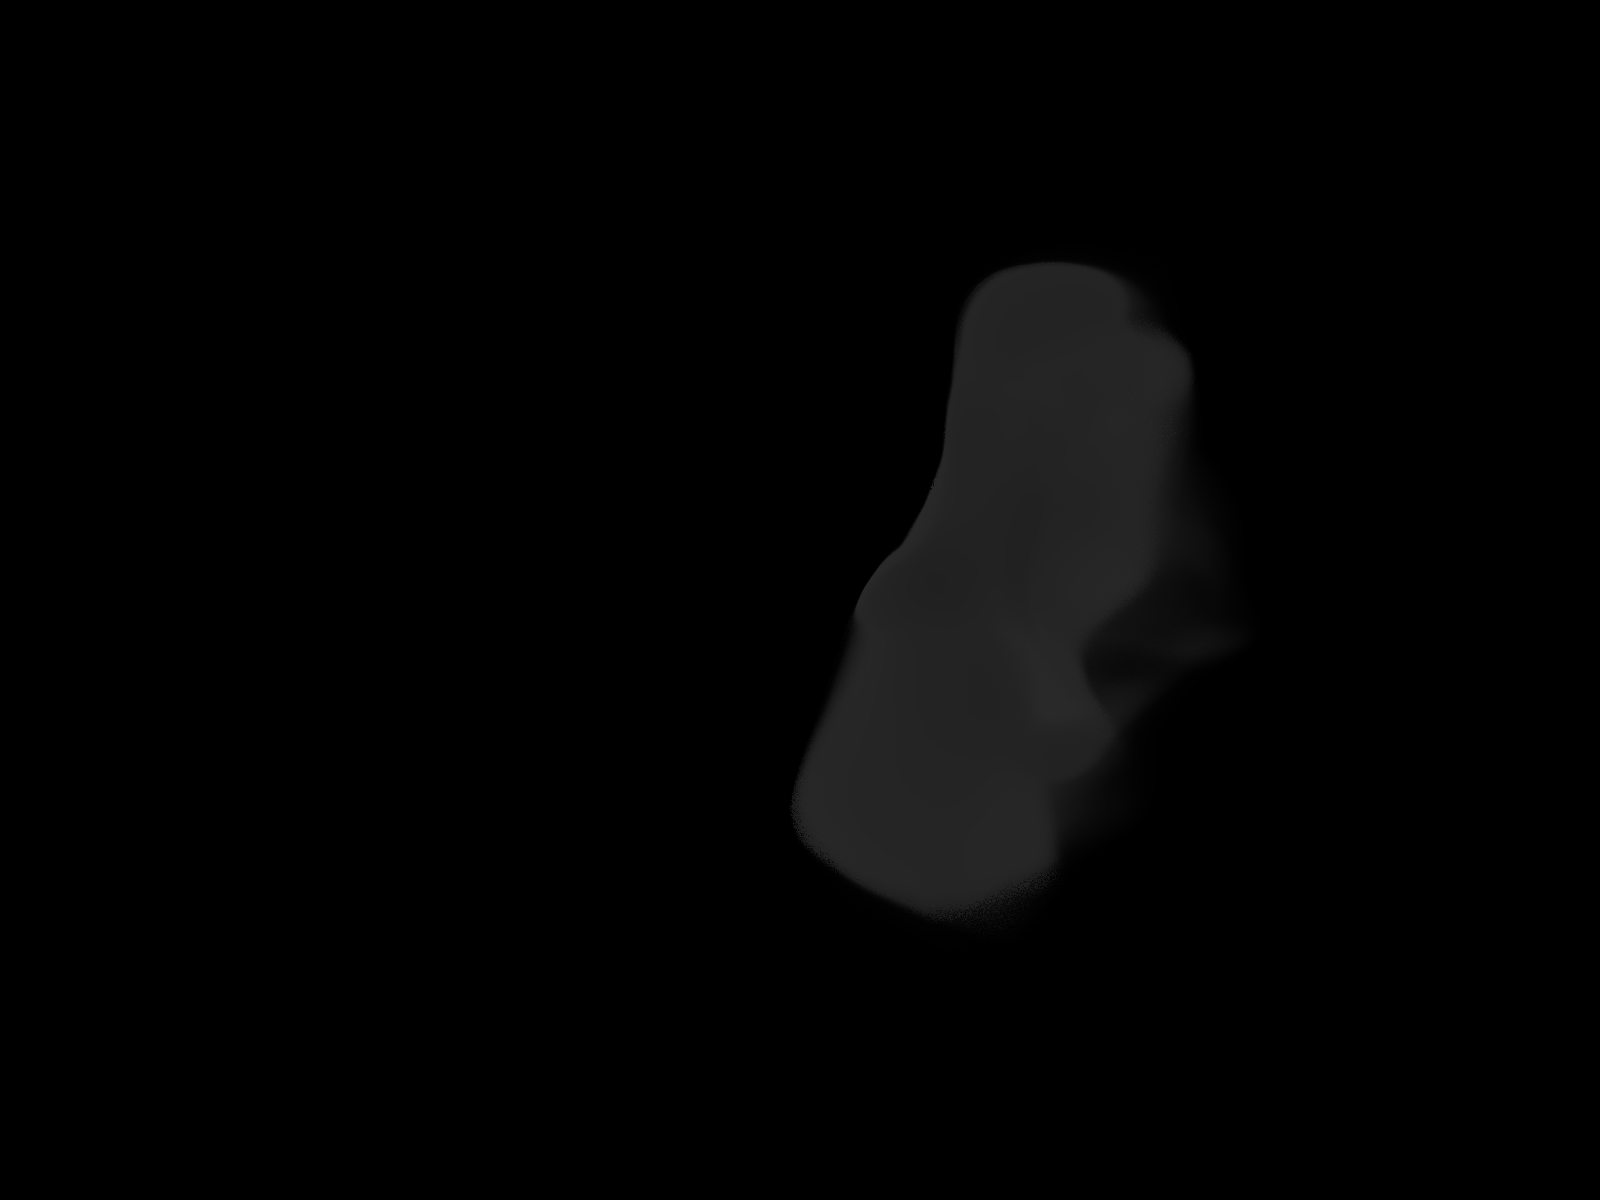

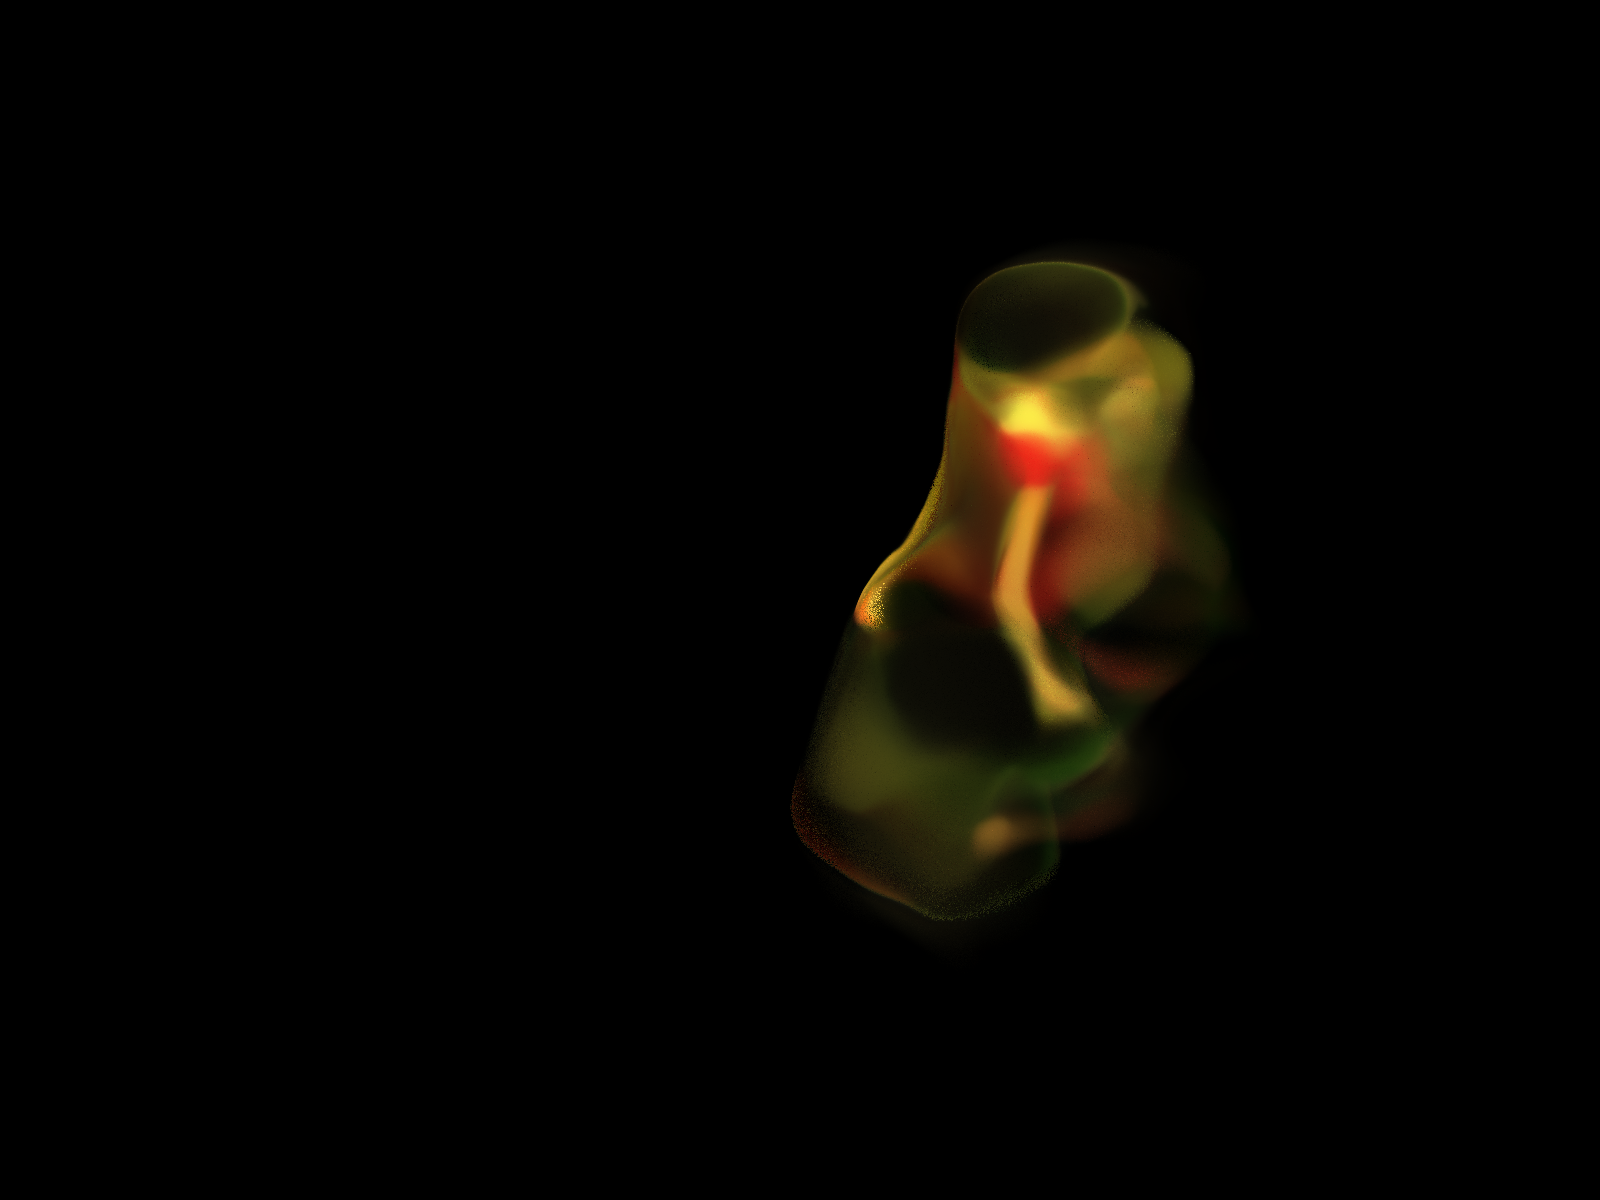

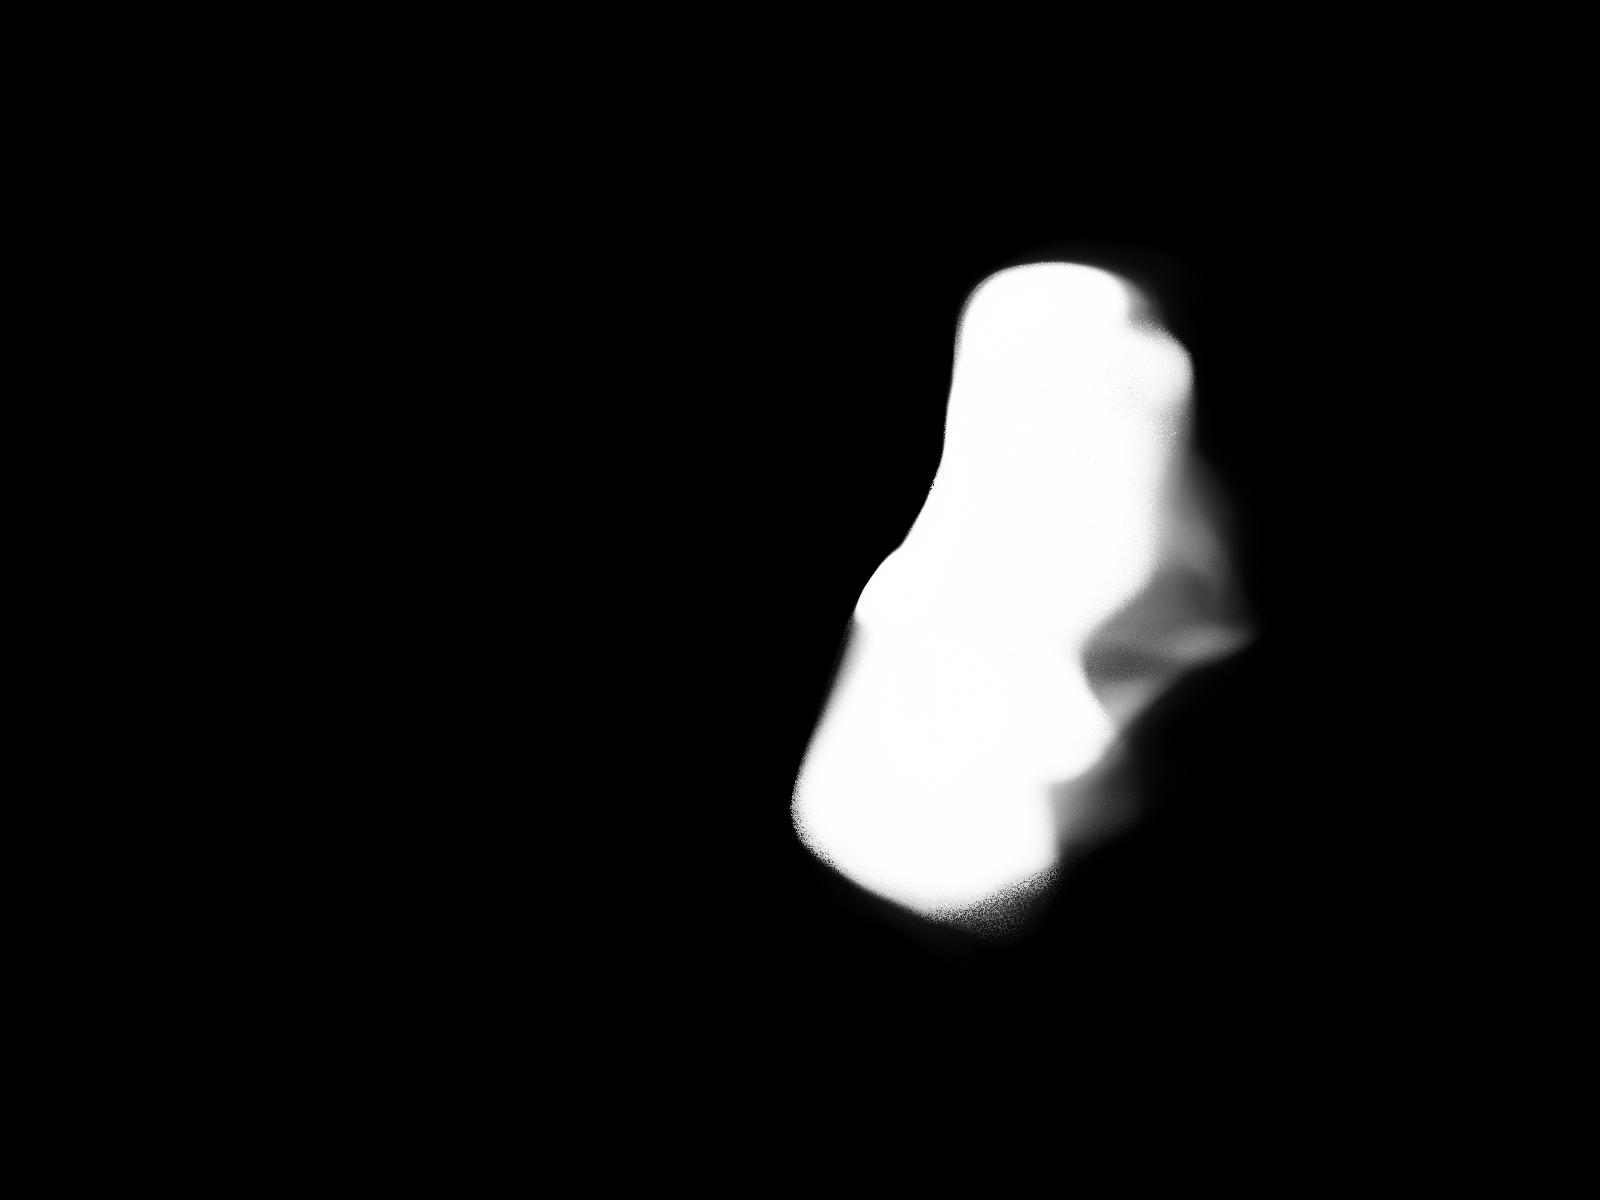

In [9]:
show_image(np.array(pred_depth[:,:,0]))
show_image(np.array(pred_color))
show_image(np.array(pred_acc[:,:,0]))

In [10]:
# @title Show rendered video.

fps = 10  # @param {type:'number'}

frames = []
for rgb, depth,acc in results:
  depth_viz = viz.colorize(depth.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  acc_viz = viz.colorize(acc.squeeze())

  frame = np.concatenate([rgb, depth_viz], axis=1)

  frames.append(image_utils.image_to_uint8(frame))

show_video(frames, fps=fps)

In [11]:
from jax import tree_util
import time
from importlib import reload  
reload(models)

model, _ = models.nerf_mesh(
    key,
    model_config,
    batch_size=train_config.batch_size,
    num_appearance_embeddings=len(datasource.appearance_ids),
    num_camera_embeddings=len(datasource.camera_ids),
    num_warp_embeddings=len(datasource.warp_ids),
    near=datasource.near,
    far=datasource.far,
    use_warp_jacobian=train_config.use_elastic_loss,
    use_weights=train_config.use_elastic_loss)

def _model_fn(key_0, key_1, params, rays_dict, alpha):
  out = model.apply({'params': params},
                    rays_dict,
                    warp_alpha=alpha,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1
                    },
                    mutable=False)
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    # key0, key1, params, rays_dict, alpha
    in_axes=(0, 0, 0, 0, 0),
    devices=devices,
    donate_argnums=(3,),  # Donate the 'rays' argument.
    axis_name='batch',
)

device_count=len(devices)
chunk=eval_config.chunk
model_fn = pmodel_fn


_, key_0, key_1 = jax.random.split(rng, 3)
key_0 = jax.random.split(key_0, device_count)
key_1 = jax.random.split(key_1, device_count)
host_id = jax.host_id()

/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/lib/xla_bridge.py:369: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [12]:
def extract_mesh(bs_pts, chunk, rays_dict, device_count, key_0, key_1, state):
    occ = []
    for i in range(0, bs_pts, chunk):
        #logging.info('\tRendering ray batch: %d/%d', i, num_rays)
        # pylint: disable=cell-var-from-loop
        chunk_slice_fn = lambda x: x[i:i + chunk]
        chunk_rays_dict = tree_util.tree_map(chunk_slice_fn, rays_dict)
        num_chunk_rays = chunk_rays_dict['query_xyz'].shape[0]
        remainder = num_chunk_rays % device_count
        if remainder != 0:
          padding = device_count - remainder
          # pylint: disable=cell-var-from-loop
          chunk_pad_fn = lambda x: jnp.pad(x, ((0, padding), (0, 0)), mode='edge')
          chunk_rays_dict = tree_util.tree_map(chunk_pad_fn, chunk_rays_dict)
        else:
          padding = 0
        # After padding the number of chunk_rays is always divisible by
        # host_count.
        per_host_rays = num_chunk_rays // jax.host_count()
        chunk_rays_dict = tree_util.tree_map(
            lambda x: x[(host_id * per_host_rays):((host_id + 1) * per_host_rays)],
            chunk_rays_dict)
        chunk_rays_dict = utils.shard(chunk_rays_dict, device_count)

        model_out = model_fn(
            key_0,
            key_1,
            state.optimizer.target['model'],
            chunk_rays_dict,
            state.warp_alpha)
        occ.append(utils.unshard(model_out['alpha'][0], padding))
    occ = jnp.concatenate(occ, axis=0)

    vol_o = np.asarray(occ.reshape((grid_size, grid_size, grid_size)))
    return vol_o

In [13]:
import trimesh
import mcubes
import cv2
import shutil

#outseqname = 'nerfies_%s'%(seqname)
outseqname = '%s'%(seqname)
target_dir='/private/home/gengshany/code/vid2shape/logdir/baseline-%s/'%outseqname
! rm -rf "$target_dir"
os.mkdir(target_dir)

In [14]:
#bound=(datasource.far-datasource.near)/4 # cat 807
#bound=(datasource.far-datasource.near)/16 # eagle
bound=(datasource.far-datasource.near) / 8 # ama

frame_len=len(test_cameras)
#render_len=15
render_len=frame_len
grid_size = 128
#grid_size = 12
#threshold = 10
threshold = 100

pts = np.linspace(-bound, bound, grid_size).astype(np.float32)
query_yxz = np.stack(np.meshgrid(pts, pts, pts), -1)  # (y,x,z)
query_yxz = query_yxz.reshape(-1, 3)
query_xyz = np.concatenate([query_yxz[:,1:2], query_yxz[:,0:1], query_yxz[:,2:3]],-1)
#query_xyz[:,-1] *= -1

bs_pts = query_xyz.shape[0]
points = query_xyz[:,None]

for tidx in range(0,render_len):
    tidxf = int(tidx/render_len*frame_len)
    print(tidxf)
    metadata={}
    metadata['appearance'] = tidxf* np.ones((points.shape[0],1)).astype(int)
    metadata['warp'] = tidxf*np.ones((points.shape[0],1)).astype(int)
    rays_dict={'query_xyz': query_xyz, 'metadata': metadata}

    vol_o = extract_mesh(bs_pts, chunk, rays_dict, device_count, key_0, key_1, state)

    print('fraction occupied:', (vol_o > threshold).astype(float).mean())
    vertices, triangles = mcubes.marching_cubes(vol_o, threshold)
    vertices = (vertices - grid_size/2)/grid_size*2
    vertices = vertices * bound

    mesh = trimesh.Trimesh(vertices, triangles)
    camtxt = np.zeros((4,4))
    camtxt[:3,:3] = test_cameras[tidxf].orientation
    camtxt[:3,3] = camtxt[:3,:3].dot(-test_cameras[tidxf].position[:,None])[:,0]
    camtxt[3,:2] = [test_cameras[tidxf].focal_length, 
                    test_cameras[tidxf].focal_length]
    camtxt[3,2:] = test_cameras[tidxf].principal_point
    

    mesh.export('%s/%s-mesh-%05d.obj'%(target_dir,outseqname,tidx))
    np.savetxt('%s/%s-cam-%05d.txt'%(target_dir,outseqname,tidx), camtxt)

0


/private/home/gengshany/.conda/envs/nerfies/lib/python3.8/site-packages/jax/lib/xla_bridge.py:382: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


fraction occupied: 0.004689693450927734
1
fraction occupied: 0.004914760589599609
2
fraction occupied: 0.004939079284667969
3
fraction occupied: 0.005198478698730469
4
fraction occupied: 0.005280017852783203
5
fraction occupied: 0.005757808685302734
6
fraction occupied: 0.0061702728271484375
7
fraction occupied: 0.006109714508056641
8
fraction occupied: 0.006410121917724609
9
fraction occupied: 0.006305694580078125
10
fraction occupied: 0.0057811737060546875
11
fraction occupied: 0.004977703094482422
12
fraction occupied: 0.005660533905029297
13
fraction occupied: 0.0052814483642578125
14
fraction occupied: 0.0050945281982421875
15
fraction occupied: 0.005083560943603516
16
fraction occupied: 0.005730628967285156
17
fraction occupied: 0.005453586578369141
18
fraction occupied: 0.00508880615234375
19
fraction occupied: 0.005511760711669922
20
fraction occupied: 0.005722999572753906
21
fraction occupied: 0.0059528350830078125
22
fraction occupied: 0.005576610565185547
23
fraction occupie